In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# some important varibles
batch_size = 32
image_size = 256
channels = 3
epochs = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/PlantVillage',
    shuffle =True ,
    image_size =(image_size,image_size)  , # image_size =(256,256,3)
    batch_size = batch_size             # 32
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
# the batch_size = 32 , its mean 1 batch have 32 tranning data
# only take one sample (mean 1 batch)
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
for element in dataset.take(1):
  print(element)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[175., 159., 169.],
         [165., 149., 159.],
         [150., 134., 144.],
         ...,
         [202., 192., 200.],
         [193., 183., 191.],
         [184., 174., 182.]],

        [[150., 134., 144.],
         [150., 134., 144.],
         [153., 137., 147.],
         ...,
         [196., 186., 194.],
         [193., 183., 191.],
         [190., 180., 188.]],

        [[147., 131., 141.],
         [155., 139., 149.],
         [170., 154., 164.],
         ...,
         [192., 182., 190.],
         [191., 181., 189.],
         [191., 181., 189.]],

        ...,

        [[175., 156., 162.],
         [147., 128., 134.],
         [165., 146., 152.],
         ...,
         [198., 183., 188.],
         [213., 198., 203.],
         [198., 183., 188.]],

        [[146., 127., 133.],
         [155., 136., 142.],
         [162., 143., 149.],
         ...,
         [153., 138., 143.],
         [170., 155., 160.],
       

In [9]:
# 1st image_batch and its output labels
for image_batch , labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch)

(32, 256, 256, 3)
tf.Tensor([1 0 0 0 0 0 0 1 1 0 1 1 0 2 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0], shape=(32,), dtype=int32)


In [10]:
# label_batch and image_batch is tesnor convert tensor to simple use numpy()
# if not use the numpy() then this is tensor form
for image_batch , labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 1 0 0 0 0 0 0 2 0 1 0 0 0 1 0 1 0 1 2 1 0 1 1 1 1 0 1 1 1 0]


(32, 256, 256, 3)
[1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0]


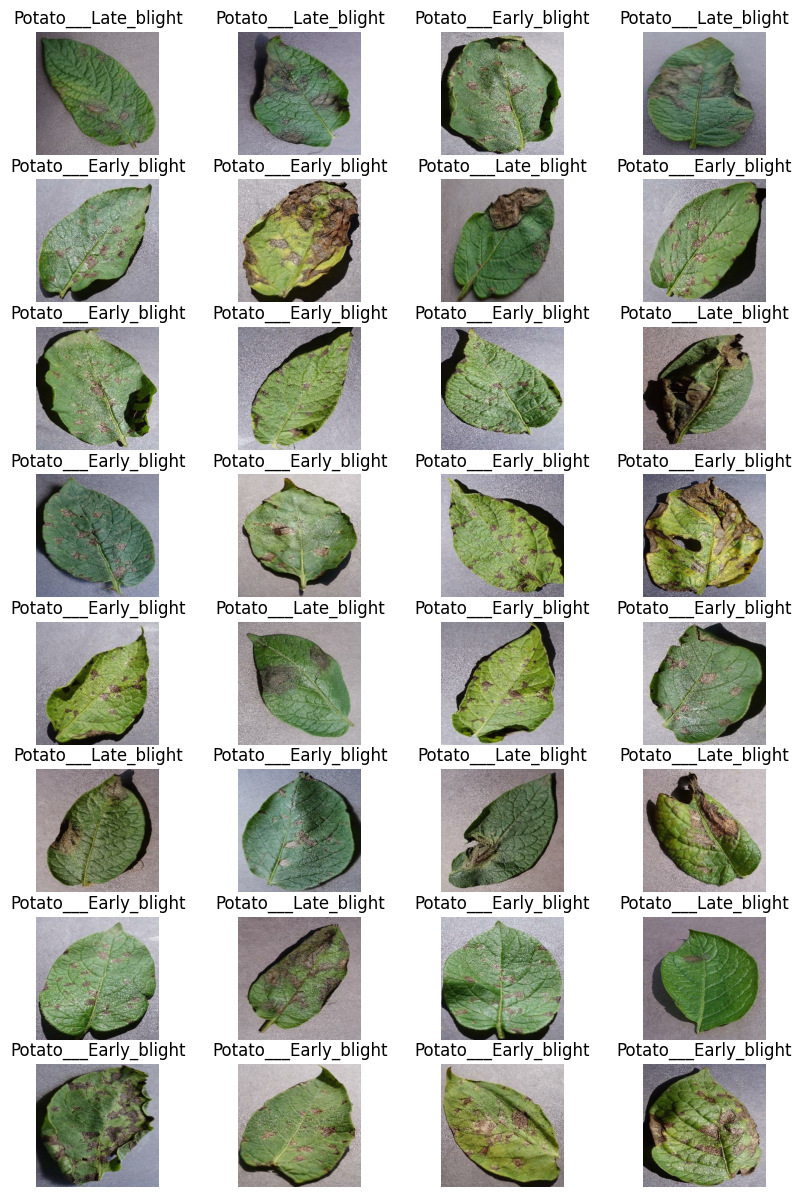

In [11]:
# visvalize the data
# 1 batch have 32 element (8,4)
plt.figure(figsize=(10,15))
for image_batch , labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[i]])
    plt.axis('off')

In [12]:
# total image is 2152
# batch_size = 32
# totle iteration = 2152/32 ~ int(67.78) == 68
len(dataset)

68

In [13]:
# split data train ,test ,validation data
# train data is 80%
# test data is 20%
#   - validation data 10% (validation data is use the traning data its use to calucluate accuracy)
#   - test data 10%

# train data (len(dataset)*0.8) -> 68*0.8 = 54.4
# validation data (len(dataset)*10) -> 68*0.1 = 6.8
# test data ()
# (train data + validation data + test data) = 1

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
# 0-54 all batch is include all train_ds
train_ds = dataset.take(54)
len(train_ds)

54

In [16]:
# above 54 ((55-68)= 14) is test_ds
test_ds = dataset.skip(54)
len(test_ds)


14

In [17]:
val_size = 0.1
len(dataset)*0.1

6.800000000000001

In [18]:
# val_ds
val_ds = test_ds.take(6)
len(val_ds)

6

In [19]:
# test_ds
test_ds = test_ds.skip(6)
len(test_ds)

8

In [20]:
# create a function train_ds , val_ds , test_ds

def train_val_test_split(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=1000):
  assert (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)
  test_size = int(ds_size*test_split)

  train_ds = ds.take(train_size)
  val_size = ds.skip(train_size).take(val_size)
  test_size = ds.skip(train_size).skip(val_size)

  return train_ds , val_ds , test_ds

In [21]:
#train_ds , val_ds , test_ds = train_val_test_split(dataset)

In [22]:
print('train_ds_size:',len(train_ds))
print('val_ds_size:',len(val_ds))
print('test_ds_size',len(test_ds))

train_ds_size: 54
val_ds_size: 6
test_ds_size 8


In [23]:
# incress the perfomance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

'''The `tf.data.Dataset.cache()` method caches the dataset in memory so that it can be accessed more quickly in the future. This can be useful for datasets that are large or that are accessed frequently.
The `tf.data.Dataset.shuffle()` method shuffles the dataset in order to randomize the order of the data. This can be useful for training models that are sensitive to the order of the data.
The `tf.data.Dataset.prefetch()` method prefetches the next batch of data from the dataset. This can be useful for speeding up training by reducing the amount of time that the model has to wait for data.
In this case, we are using the `tf.data.Dataset.cache()` method to cache the dataset in memory, the `tf.data.Dataset.shuffle()` method to shuffle the dataset, and the `tf.data.Dataset.prefetch()` method to prefetch the next batch of data. This will help to speed up the training process.
'''


'The `tf.data.Dataset.cache()` method caches the dataset in memory so that it can be accessed more quickly in the future. This can be useful for datasets that are large or that are accessed frequently.\nThe `tf.data.Dataset.shuffle()` method shuffles the dataset in order to randomize the order of the data. This can be useful for training models that are sensitive to the order of the data.\nThe `tf.data.Dataset.prefetch()` method prefetches the next batch of data from the dataset. This can be useful for speeding up training by reducing the amount of time that the model has to wait for data.\nIn this case, we are using the `tf.data.Dataset.cache()` method to cache the dataset in memory, the `tf.data.Dataset.shuffle()` method to shuffle the dataset, and the `tf.data.Dataset.prefetch()` method to prefetch the next batch of data. This will help to speed up the training process.\n'

In [24]:
for image_batch , labels_batch in dataset.take(1):
  print(image_batch[0].shape)

(256, 256, 3)


In [25]:
image_size = 256

In [26]:
# resize the image in (256,256,3)
# rescaling the data 1/255
# add new layer in CNN architecture

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size,image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
])

In [28]:
input_shape = (batch_size, image_size,image_size,channels)
n_classes = 3

In [29]:
from keras.layers.serialization import activation
# CNN arcitecture
model = Sequential()

# layer 1 : resize_and_recaling
model.add(resize_and_rescale)

# layer 2 : data augmentation
model.add(data_augmentation)

# layer 3 : Conv2D
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))

# layer 4 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 5 : Conv2D
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# layer 6 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 7 : Conv2D
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# layer 8 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 9 : Conv2D
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# layer 10 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 11 : Conv2D
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# layer 12 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 13 : Conv2D
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# layer 14 : MaxPolling layer
model.add(MaxPooling2D(2,2))

# layer 14 : Flatten layer
model.add(Flatten())

# layer 15 : FullyConnected Layer
model.add(Dense(64,activation='relu'))

# layer 16 : Output layer
model.add(Dense(n_classes,activation='softmax'))


In [30]:
model.build(input_shape = input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
# fit the model
result = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 [==============================] - 55s 160ms/step - loss: 0.9059 - accuracy: 0.5000 - val_loss: 0.8031 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.6678 - accuracy: 0.7199 - val_loss: 0.4598 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 4s 73ms/step - loss: 0.5043 - accuracy: 0.8038 - val_loss: 0.4744 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 4s 73ms/step - loss: 0.4723 - accuracy: 0.8177 - val_loss: 0.4495 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 4s 70ms/step - loss: 0.3214 - accuracy: 0.8657 - val_loss: 0.3713 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 4s 65ms/step - loss: 0.2760 - accuracy: 0.9010 - val_loss: 0.2547 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 3s 64ms/step - loss: 0.2148 - accuracy: 0.9225 - val_loss: 0.4100 - val_accuracy: 0.8490
Epoch 8/50


In [34]:
# apply test data
score = model.evaluate(test_ds)
score

8/8 [==============================] - 6s 74ms/step - loss: 0.3296 - accuracy: 0.9095


[0.32957369089126587, 0.9094827771186829]

In [35]:
result.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
print(result.history['accuracy'] ,'\n', result.history['val_accuracy'] ,'\n', result.history['loss'] ,'\n', result.history['val_loss'])

[0.5, 0.7199074029922485, 0.8038194179534912, 0.8177083134651184, 0.8657407164573669, 0.9010416865348816, 0.9224537014961243, 0.9375, 0.9403935074806213, 0.9600694179534912, 0.9513888955116272, 0.9508101940155029, 0.9600694179534912, 0.9525462985038757, 0.9432870149612427, 0.9675925970077515, 0.9409722089767456, 0.9583333134651184, 0.9513888955116272, 0.9600694179534912, 0.96875, 0.9664351940155029, 0.9768518805503845, 0.9681712985038757, 0.9716435074806213, 0.9855324029922485, 0.9762731194496155, 0.9704861044883728, 0.9872685074806213, 0.9728009104728699, 0.9785879850387573, 0.9716435074806213, 0.9837962985038757, 0.9855324029922485, 0.9861111044883728, 0.9895833134651184, 0.9878472089767456, 0.9739583134651184, 0.9866898059844971, 0.9837962985038757, 0.9826388955116272, 0.9780092835426331, 0.9745370149612427, 0.9751157164573669, 0.9832175970077515, 0.9797453880310059, 0.9832175970077515, 0.9803240895271301, 0.9924768805503845, 0.9901620149612427] 
 [0.6510416865348816, 0.84375, 0.817

In [38]:
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

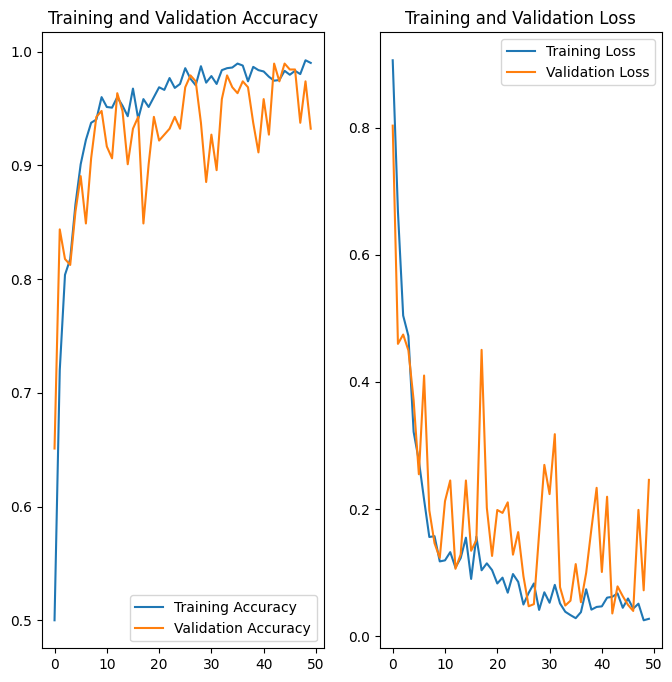

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
for image_batch , label_batch in test_ds.take(1):
  print(image_batch[0])
  print('\n')
  print(label_batch[0])

tf.Tensor(
[[[168. 166. 177.]
  [169. 167. 178.]
  [169. 167. 178.]
  ...
  [158. 155. 164.]
  [149. 146. 155.]
  [136. 133. 142.]]

 [[162. 160. 171.]
  [163. 161. 172.]
  [166. 164. 175.]
  ...
  [153. 150. 159.]
  [151. 148. 157.]
  [139. 136. 145.]]

 [[158. 156. 167.]
  [159. 157. 168.]
  [161. 159. 170.]
  ...
  [146. 143. 152.]
  [149. 146. 155.]
  [138. 135. 144.]]

 ...

 [[182. 180. 185.]
  [185. 183. 188.]
  [193. 191. 196.]
  ...
  [161. 156. 162.]
  [159. 154. 160.]
  [166. 161. 167.]]

 [[181. 179. 184.]
  [191. 189. 194.]
  [190. 188. 193.]
  ...
  [158. 153. 159.]
  [155. 150. 156.]
  [163. 158. 164.]]

 [[172. 170. 175.]
  [186. 184. 189.]
  [181. 179. 184.]
  ...
  [152. 147. 153.]
  [148. 143. 149.]
  [156. 151. 157.]]], shape=(256, 256, 3), dtype=float32)


tf.Tensor(0, shape=(), dtype=int32)


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 467ms/step
predicted label: Potato___Early_blight


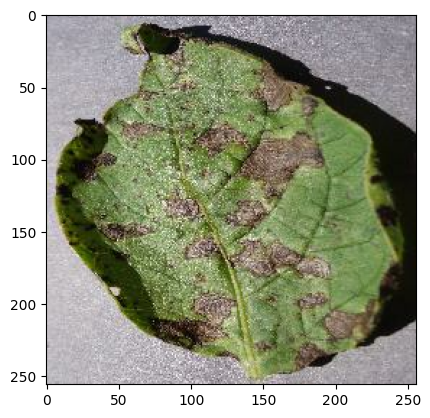

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
# function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


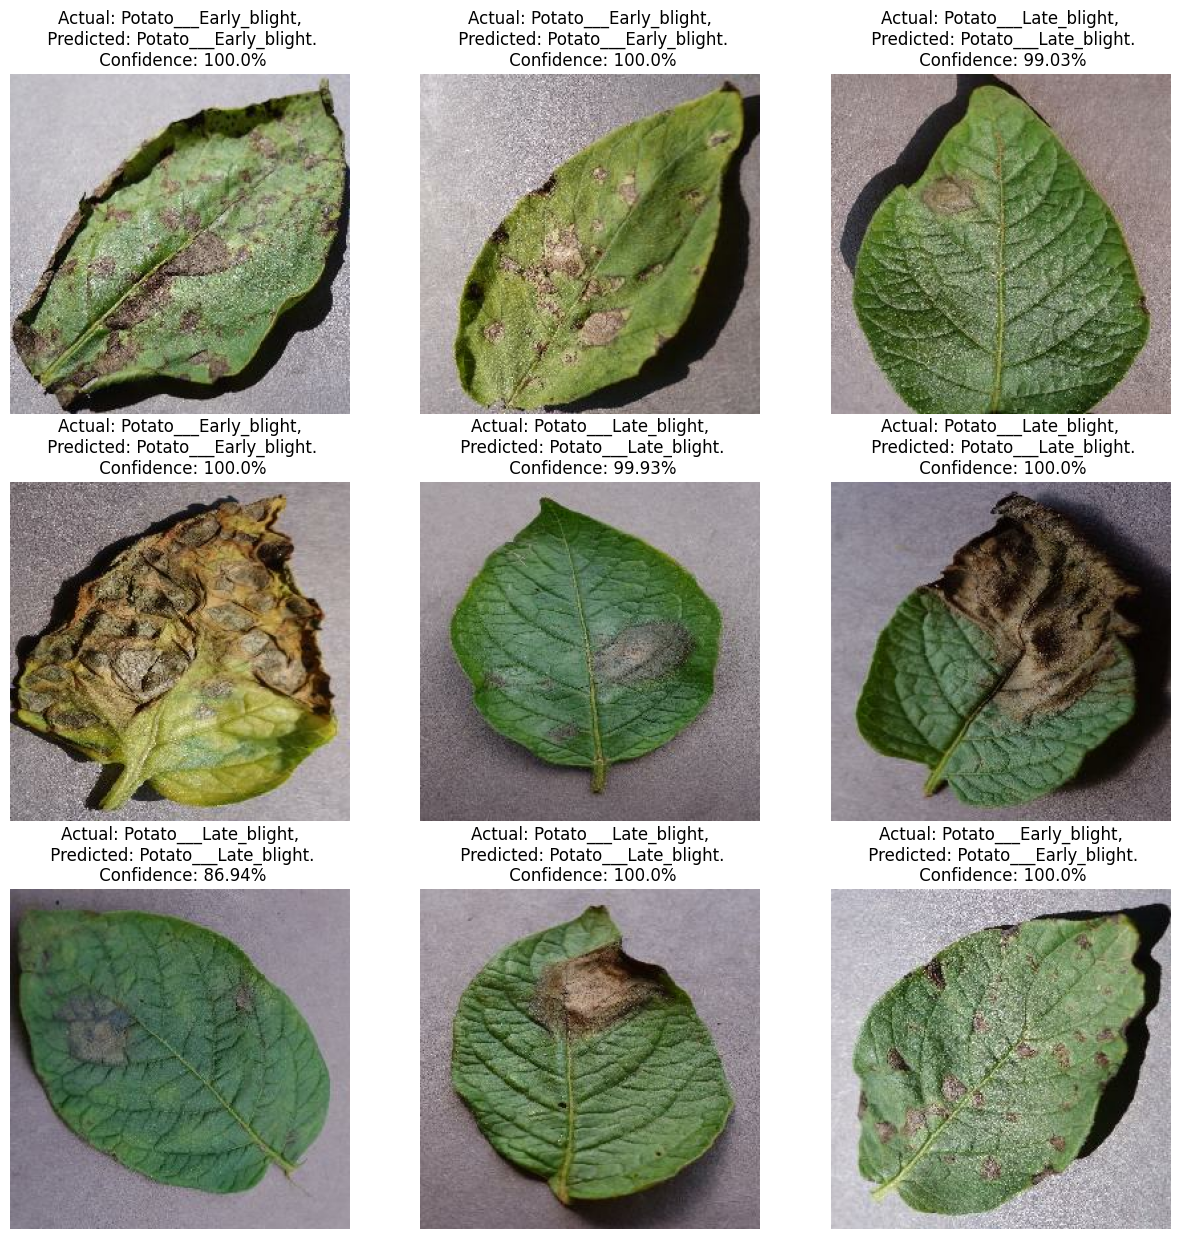

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [44]:
# save the model
import os
model.save('/content/drive/MyDrive/CNN_Potato_classfication/Model')

In [45]:
model.save('model.h5')